# MiniProject  👁️ Image Recognition multiclass classification Landscapes  
##  🏢🌲🧊⛰️🌊🏙️
### Wesley, Keven, Didier, Celso  

### Loading Data 📦

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path
import os
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np 
from keras.preprocessing import image

path = os.getcwd()

 
image_size = (80,80)
used_color = "rgb"
color_channels = 3 if used_color == "rgb" else 1
class_labels = [
    "buildings",
     "forest",
     "glacier",
     "mountain",
     "sea",
     "street"
]

data_path = path+"/Data/seg_"

x_train = np.ndarray((0,image_size[0],image_size[1],color_channels)) 
x_test = np.ndarray((0,image_size[0],image_size[1],color_channels)) 

def make_Y(TypeOfSet):
    path=data_path+TypeOfSet
    Data_dir_content = os.listdir(path)
    resulting_y = []

    for label in Data_dir_content:
        label_dir_content = os.listdir(path+f"/{label}")

        for _ in range(len(label_dir_content)):
            resulting_y.append(class_labels.index(label))

    return resulting_y

def make_X(TypeOfSet):
    path=data_path+TypeOfSet
    Data_dir_content = os.listdir(path)
    resulting_X = np.ndarray((0,image_size[0],image_size[1],color_channels))

    for label in Data_dir_content:
        label_dir_path=path+f"/{label}"
        label_dir_content = os.listdir(label_dir_path)

        for element in label_dir_content:
           processed_img = prepare_img_for_model(label_dir_path+f"/{element}")
           resulting_X = np.append(resulting_X,processed_img,axis=0)

    return resulting_X

def prepare_img_for_model(path):
    img = image.load_img(path,target_size=(image_size),color_mode=used_color)
    image_as_array = image.img_to_array(img)
    image_reshaped = image_as_array.reshape(image_size[0],image_size[1],color_channels)
    return np.expand_dims( image_reshaped, axis=0)


x_test = make_X("test")
x_train =make_X("train")


# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

 
y_train = make_Y("train")
y_test = make_Y("test")

# y_train = to_categorical(y_train, 6)
# y_test = to_categorical(y_test, 6)
  

KeyboardInterrupt: 

In [10]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(0, 15)), # crop 10% of the iamges from each side by 0 to 1/4 of the sizepx (randomly chosen)
    # iaa.Rot90(0.25), # horizontally flip 25% of the images
    iaa.Fliplr(0.10),
    iaa.Flipud(0.10),
]) 

augmented_images = seq(images=x_train)
# x_train /= 255

x_train = np.append(x_train,augmented_images,axis=0)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train =np.append(y_train,y_train,axis=0)

y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)

In [37]:
model = Sequential()
# 2D convolutional layers for images 1D can fit for other kind like Sound
# Params:
# 1 filters :how many differnet filters should be in the layer, one filter by pattern
# 2 kernel_size : size of the window used when creating the tiles for each image
# 3 padding: in case the kernel size doesnt match the corner ignore or fill with 0
model.add(Conv2D(filters=64, kernel_size=(10,10), padding="same",activation='relu', input_shape=(image_size[0],image_size[1],color_channels),name="Conv2D_1"))
model.add(Conv2D(filters=64, kernel_size=(5,5),activation='relu', name="Conv2D_2"))

#max pooling
model.add(MaxPooling2D(pool_size=(4,4)))
#Dropout, randomly cut connections, normally used between [25-50]%
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding="same", activation='relu', name="Conv2D_3"))
model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu',name="Conv2D_4"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#To transition from Convolutional layers to Dense layers we need to tell karas that we no longer want to use 2D data
model.add(Flatten())
model.add(Dense(512,activation='relu', name="DenseLayer_1"))
model.add(Dropout(0.25))
model.add(Dense(512,activation='relu', name="DenseLayer_2"))
# when doing classificaton with more than one kind of object we almost always use softmax activator for the output
model.add(Dense(6, activation="softmax", name="output_layer"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 80, 80, 64)        19264     
                                                                 
 Conv2D_2 (Conv2D)           (None, 76, 76, 64)        102464    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 19, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 19, 19, 64)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 19, 19, 64)        36928     
                                                                 
 Conv2D_4 (Conv2D)           (None, 17, 17, 64)        36928     
                                                      

In [38]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [39]:
# from keras.callbacks import ModelCheckpoint
#We use the ModelCheckpoint API to save the model after every epoch. Set "save_best_only = True" to save only when the validation accuracy improves.
# tensorboard --logdir=/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/logs
runPath = path+"/logs/SeventeenthRun"
# runPath = path+"/logs/EigthRun"
logger =  keras.callbacks.TensorBoard(
    log_dir=runPath,
    write_graph=True, #log the structure of the model
    histogram_freq =5 #how each layer is working (for every 5 passes of the training data)
)


# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=10,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[logger]
    # callbacks=[logger,checkpointer]
)


2022-04-01 13:54:07.317456: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.01GiB (rounded to 2155622400)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-01 13:54:07.317485: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-01 13:54:07.317494: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 278, Chunks in use: 278. 69.5KiB allocated for chunks. 69.5KiB in use in bin. 13.2KiB client-requested in use in bin.
2022-04-01 13:54:07.317499: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-04-01 13:54:07.317504: I tensorflow

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

 9, Chunks in use: 7. 668.8KiB allocated for chunks. 491.8KiB in use in bin. 465.3KiB client-requested in use in bin.
2022-04-01 13:54:07.317537: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (131072): 	Total Chunks: 31, Chunks in use: 29. 4.44MiB allocated for chunks. 4.16MiB in use in bin. 4.08MiB client-requested in use in bin.
2022-04-01 13:54:07.317541: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (262144): 	Total Chunks: 2, Chunks in use: 2. 662.2KiB allocated for chunks. 662.2KiB in use in bin. 544.0KiB client-requested in use in bin.
2022-04-01 13:54:07.317545: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (524288): 	Total Chunks: 10, Chunks in use: 9. 5.50MiB allocated for chunks. 4.92MiB in use in bin. 4.50MiB client-requested in use in bin.
2022-04-01 13:54:07.317550: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (1048576): 	Total Chunks: 9, Chunks in use: 7. 10.17MiB allocated for chunks. 7.98MiB in use in bin. 7.02Mi

In [15]:

test_error_rate = model.evaluate(x_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

2022-04-01 13:11:21.045643: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 796.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


The mean squared error (MSE) for the test data set is: [0.6583924293518066, 0.8240000009536743]


In [161]:
# Save neural network structure
model_structure = model.to_json()
f = Path(path+"/SavedModel/model_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights(path+"/SavedModel/model_weights.h5")

## ------------------------------------------------------Testing Images ------------------------------------------------------

array([0., 0., 0., 0., 1., 0.], dtype=float32)

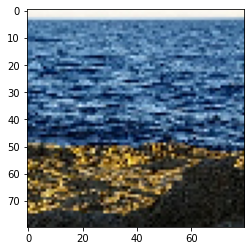

In [36]:
test_pos = 11006
plt.imshow(x_train[test_pos]) 
y_train[test_pos]

---------------------------------------------------------------------- 

For the image of: forest.jpg
The trained model predicted this image is a forest
ResNet50 predicted the image is a mountain_bike
---------------------------------------------------------------------- 

For the image of: building.jpg
The trained model predicted this image is a buildings
ResNet50 predicted the image is a breakwater
---------------------------------------------------------------------- 

For the image of: glacier.jpg
The trained model predicted this image is a buildings
ResNet50 predicted the image is a alp
---------------------------------------------------------------------- 

For the image of: mountain.jpg
The trained model predicted this image is a buildings
ResNet50 predicted the image is a alp
---------------------------------------------------------------------- 

For the image of: sea.jpg
The trained model predicted this image is a glacier
ResNet50 predicted the image is a seashore
-----------

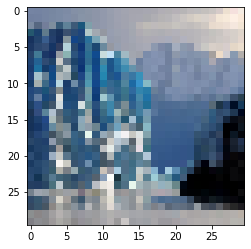

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np
import re
# Load the json file that contains the model's structure
# f = Path(path+"/SavedModel/model_structure.json")
# model_structure = f.read_text()
# Recreate the Keras model object from the json data
# model = model_from_json(model_structure)
# model.load_weights(path+"/SavedModel/model_weights.h5")
 
pretrained_model = ResNet50(weights='imagenet')

def prepare_img_for_prediction(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

krkrk = image.load_img(path+"/Data/RandomTestPics/glacier.jpg", target_size=(30, 30))
plt.imshow(krkrk)  


test_images = [
path+"/Data/RandomTestPics/forest.jpg",
path+"/Data/RandomTestPics/building.jpg",
path+"/Data/RandomTestPics/glacier.jpg",
path+"/Data/RandomTestPics/mountain.jpg",
path+"/Data/RandomTestPics/sea.jpg",
path+"/Data/RandomTestPics/street.jpg"
]

for img_path in test_images:
    print("---------------------------------------------------------------------- \n")
    print(f"For the image of: {img_path.split('/')[9]}")
    resNet_image = image.load_img(img_path, target_size=(224, 224))
    # plt.imshow(resNet_image)    

    model_image = image.load_img(img_path, target_size=(image_size),color_mode=used_color)
    # plt.imshow(model_image)    
    model_image_ready = prepare_img_for_prediction(model_image)

    result = model.predict(model_image_ready)[0]
    most_likely_class_index = int(np.argmax(result))
    class_label = class_labels[most_likely_class_index]
    print(f"The trained model predicted this image is a {class_label}")

    pretrained_image_ready = prepare_img_for_prediction(resNet_image)
    pretrained_image_ready= preprocess_input(pretrained_image_ready)

    preds = pretrained_model.predict(pretrained_image_ready)
    predicted_classes = decode_predictions(preds, top=1)

    print(f"ResNet50 predicted the image is a {predicted_classes[0][0][1]}")
